# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

from dyn_cond_fig_functions import *

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

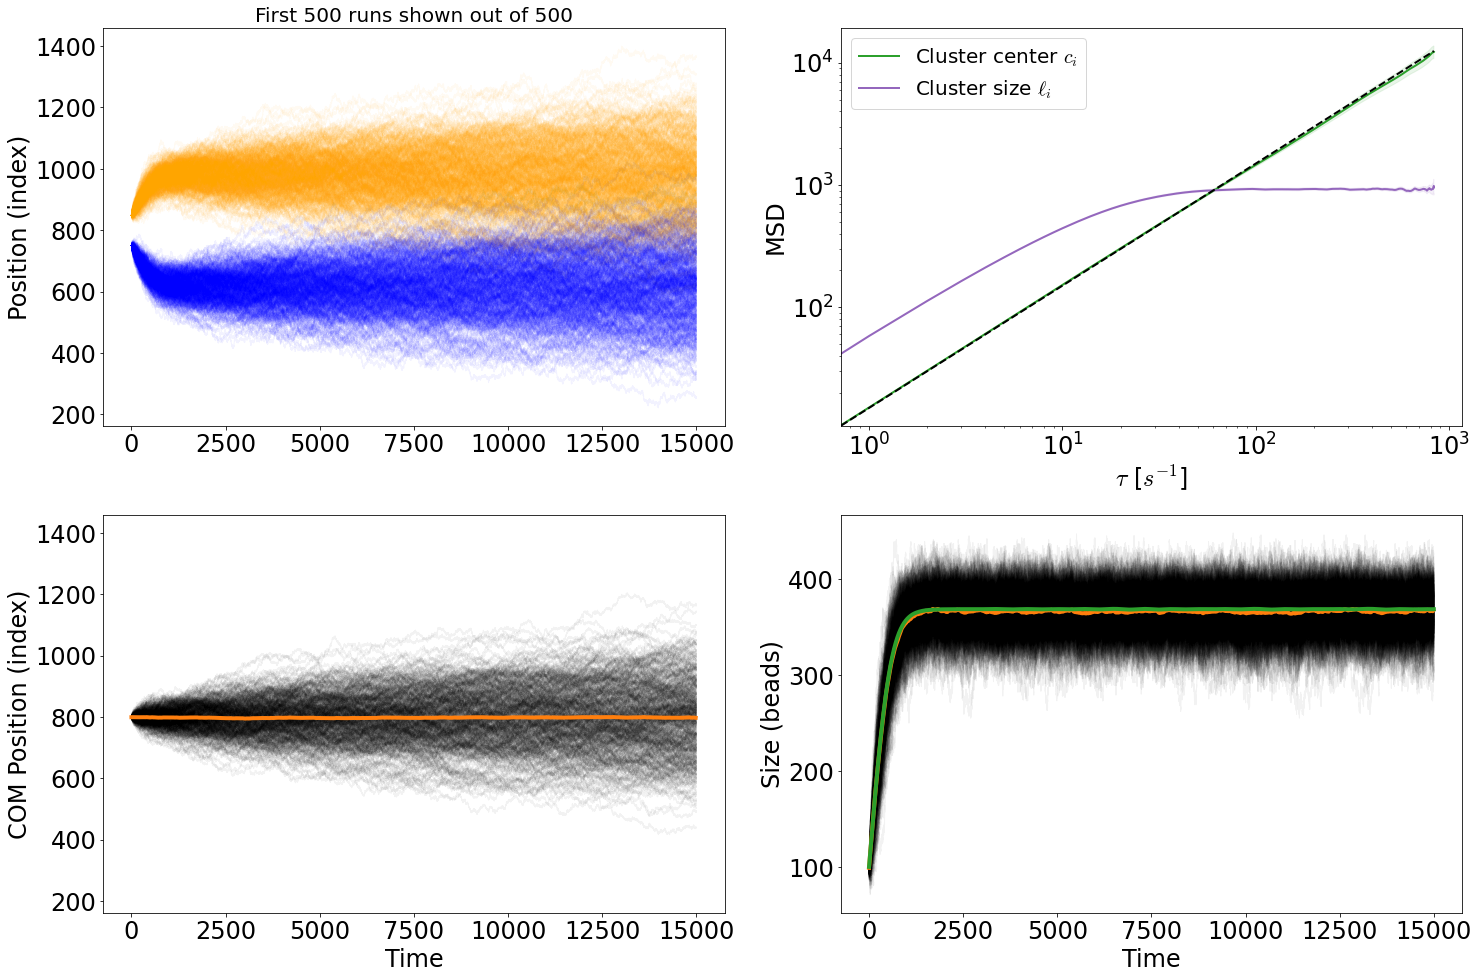

In [59]:
fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
axarr[1,0].sharey(axarr[0,0])
n_graph_runs = 500

# avg_t_com_arr, avg_com_arr = find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
# avg_t_size_arr, avg_size_arr = find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)

with h5py.File(ceph_path / 'DynCondPaper/minimal_cond_runs/24-05-17_Renger1600_1blob_L9_nruns500/24-05-17_Renger1600_1blob_L9_nruns500.h5', 'r') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])

    nu = params['kinetics']['nu']
    gamma = params['kinetics']['gamma']
    alpha = params['kinetics']['alpha']
    kappa = params['kinetics']['kappa']
    L = params['kinetics']['L']
    b = params['kinetics']['bd']
    Lc = params['n_beads'] * b
    beta = 1./.00411
    t_max = params['t_max']
    ko = 15

    time_arr_list = []
    com_arr_list = []
    size_arr_list = []

    for group in h5_data.keys():
        if 'run' not in group:
            continue
        group_data = h5_data[group]
        time_arr = group_data['times'][...]
        state_arr = group_data['states'][...]

        size_arr = np.diff(state_arr, axis=-1)[:,0].astype('float')
        # print(size_arr.shape)
        # assert(False)

        com_arr = state_arr.mean(axis=-1)

        _ = axarr[0][0].plot(time_arr, state_arr[:, 0], color='b', alpha=.05, lw=1)
        _ = axarr[0][0].plot(time_arr, state_arr[:, 1],
                            color='orange', alpha=.05, lw=1)
        _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
        _ = axarr[1][1].plot(time_arr, size_arr, color='k', alpha=.05, lw=1)
        # time_arr_list.append(time_arr)
        # com_arr_list.append(com_arr)
        # size_arr_list.append(size_arr)
        _, com_arr = calc_regular_interval_kmc_array(time_arr, com_arr, t_max, t_max/1000) 
        time_arr, size_arr = calc_regular_interval_kmc_array(time_arr, size_arr, t_max, t_max/1000) 
        time_arr_list.append(time_arr)
        com_arr_list.append(com_arr)
        size_arr_list.append(size_arr)

    msd_ind = np.argmax(time_arr > 2500)

    

    avg_t_com_arr, avg_com_arr = find_avg_val_arr(time_arr_list, com_arr_list, n_timesteps=1000)
    avg_t_size_arr, avg_size_arr = find_avg_val_arr(time_arr_list, size_arr_list, n_timesteps=1000)
    _ = axarr[1][0].plot(avg_t_com_arr, avg_com_arr, color='C1', linewidth=4)
    _ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='C1', linewidth=4)

    com_mat = np.vstack(com_arr_list)[:,msd_ind:]
    msd = condensate_msd(com_mat, device=device).cpu()
    plot_confidence_int(axarr[0][1], time_arr[:-msd_ind]/ko, msd.mean(dim=0), msd.std(dim=0), num_runs=msd.shape[0], color='C2', ci=.95, label='Cluster center $c_i$')

    size_mat = np.vstack(size_arr_list)[:,msd_ind:]
    msd = condensate_msd(size_mat, device=device).cpu()
    plot_confidence_int(axarr[0][1], time_arr[:-msd_ind]/ko, msd.mean(dim=0), msd.std(dim=0), num_runs=msd.shape[0], color='C4', ci=.95, label='Cluster size $\ell_i$')
    _ = axarr[0][1].legend()
    
    _ = axarr[0][1].loglog(time_arr[:-msd_ind]/ko, time_arr[:-msd_ind], 'k--')
    # _ = axarr.loglog(regular_time_arr, regular_time_arr/2., '--', c='C1')

    _ = axarr[0][1].set_xscale('log')
    _ = axarr[0][1].set_yscale('log')

    _ = axarr[0][1].set_ylabel('MSD')
    _ = axarr[0][1].set_xlabel(r'$\tau$ [$s^{-1}$]')


    sol = solve_ivp(
        one_cond_size_continuous_deriv,
        [0, t_max],
        [1],
        args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
        dense_output=True,
    )
    t = np.linspace(0, t_max, 1000)
    _ = axarr[1,1].plot(t, sol.sol(t).T/b, color="C2", label="Mean-field", linestyle='-', linewidth=4)
        
        
    # Simulation plotting
    # _ = axarr[0, 1].hist(tmp_fpt, density=True, bins=100,
    #                      label='Gillespie simulation')
    # _ = axarr[0, 1].axvline(np.mean(tmp_fpt), color='r',
    #                         label=f'Sim mean = {np.mean(tmp_fpt):.3g}')
    _ = axarr[0, 0].set_title(
        f'First {n_graph_runs} runs shown out of {len(h5_data.keys())}')
    #_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic")
    _ = axarr[1, 0].set_xlabel('Time')
    _ = axarr[1, 1].set_xlabel('Time')

    _ = axarr[0, 0].set_ylabel('Position (index)')
    _ = axarr[1, 0].set_ylabel('COM Position (index)')
    _ = axarr[1, 1].set_ylabel('Size (beads)')

    _ = axarr[0, 1].legend()
    #_ = axarr[1].set_yscale('log')
    fig.tight_layout()

Text(0, 0.5, '$x^L_1 - x^R_0$ MSD')

Text(0.5, 0, '$\\tau$ [s]')

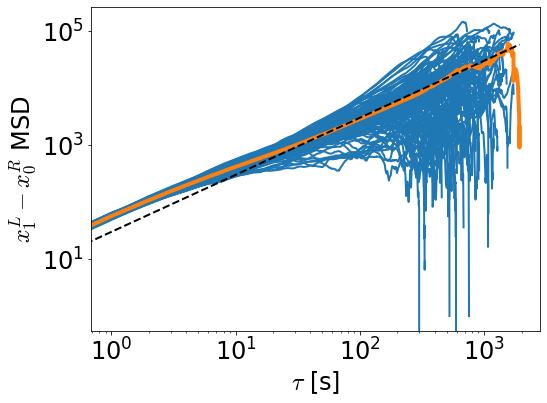

In [17]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
n_graph_runs = 500

data_path =  next(ceph_path.glob('DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep100_L5/*.h5'))
with h5py.File(data_path, 'r') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])

    nu = params['kinetics']['nu']
    gamma = params['kinetics']['gamma']
    alpha = params['kinetics']['alpha']
    kappa = params['kinetics']['kappa']
    L = params['kinetics']['L']
    b = params['kinetics']['bd']
    Lc = params['n_beads'] * b
    beta = 1./.00411
    # t_max = params['t_max']
    ko = 15

    time_arr_list = []
    com_arr_list = []
    size_arr_list = []

    edge_diff_msd_list = []
    time_arr_list = []
    max_time_arr = np.array([])
    for group in h5_data.keys():
        if 'run' not in group:
            continue
        group_data = h5_data[group]

        last_sizes = group_data['sizes'][0, -1]
        if not(last_sizes[0] == 0 or last_sizes[1] == 0):
            continue
        time_arr = group_data['times'][...]

        state_arr = group_data['states'][...]
        l_diff = state_arr[:,1,0] - state_arr[:,0,1] 
        reg_time_arr, reg_l_diff = calc_regular_interval_kmc_array(time_arr, l_diff, time_arr[-1], 15)
        if len(reg_time_arr) > len(max_time_arr):
            max_time_arr = reg_time_arr
        edge_diff_msd_list.append(condensate_msd(reg_l_diff[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(reg_time_arr/ko, edge_diff_msd_list[-1], color='C0')
        time_arr_list.append(reg_time_arr)

    avg_size_arr = mean_of_arrays(edge_diff_msd_list)
    _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4)
    _ = axarr.loglog(max_time_arr/ko, 2*max_time_arr, color='k', linestyle='--')
    
    _ = axarr.set_ylabel('$x^L_1 - x^R_0$ MSD') 
    _ = axarr.set_xlabel(r'$\tau$ [s]')

    fig.tight_layout()

Text(0, 0.5, '$x^L_1 - x^R_0$ MSD')

Text(0.5, 0, '$\\tau$ [s]')

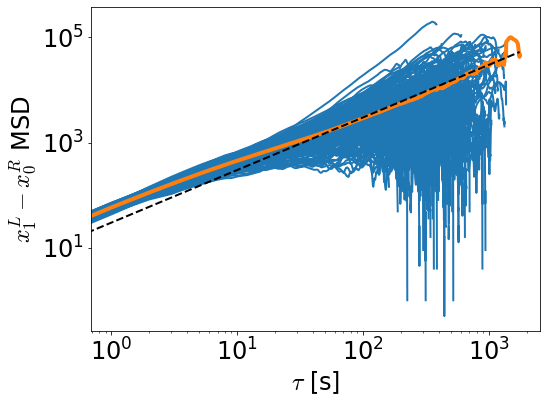

In [16]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
n_graph_runs = 500

data_path =  next(ceph_path.glob('DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep200_L7/*.h5'))
with h5py.File(data_path, 'r') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])

    nu = params['kinetics']['nu']
    gamma = params['kinetics']['gamma']
    alpha = params['kinetics']['alpha']
    kappa = params['kinetics']['kappa']
    L = params['kinetics']['L']
    b = params['kinetics']['bd']
    Lc = params['n_beads'] * b
    beta = 1./.00411
    # t_max = params['t_max']
    ko = 15

    time_arr_list = []
    com_arr_list = []
    size_arr_list = []

    edge_diff_msd_list = []
    time_arr_list = []
    max_time_arr = np.array([])
    for group in h5_data.keys():
        if 'run' not in group:
            continue
        group_data = h5_data[group]

        last_sizes = group_data['sizes'][0, -1]
        if not(last_sizes[0] == 0 or last_sizes[1] == 0):
            continue
        time_arr = group_data['times'][...]

        state_arr = group_data['states'][...]
        l_diff = state_arr[:,1,0] - state_arr[:,0,1] 
        reg_time_arr, reg_l_diff = calc_regular_interval_kmc_array(time_arr, l_diff, time_arr[-1], 15)
        if len(reg_time_arr) > len(max_time_arr):
            max_time_arr = reg_time_arr
        edge_diff_msd_list.append(condensate_msd(reg_l_diff[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(reg_time_arr/ko, edge_diff_msd_list[-1], color='C0')
        time_arr_list.append(reg_time_arr)

    avg_size_arr = mean_of_arrays(edge_diff_msd_list)
    _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4)
    _ = axarr.loglog(max_time_arr/ko, 2*max_time_arr, color='k', linestyle='--')
    
    axarr.set_ylabel('$x^L_1 - x^R_0$ MSD') 
    axarr.set_xlabel(r'$\tau$ [s]')

    fig.tight_layout()

Text(0, 0.5, '$x^R_1 - x^L_0$ MSD')

Text(0.5, 0, '$\\tau$ [s]')

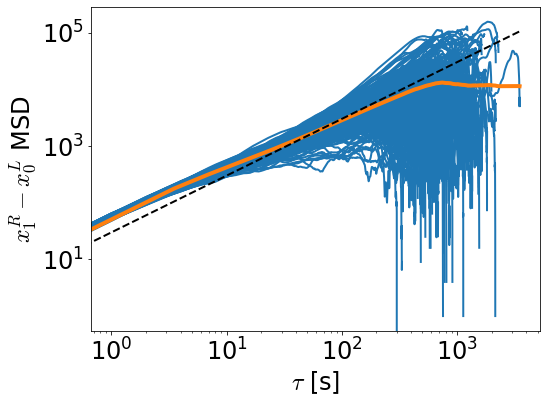

In [26]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
n_graph_runs = 500

data_path =  next(ceph_path.glob('DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep200_L5/*.h5'))
with h5py.File(data_path, 'r') as h5_data:
    params = yaml.safe_load(h5_data.attrs['params'])

    nu = params['kinetics']['nu']
    gamma = params['kinetics']['gamma']
    alpha = params['kinetics']['alpha']
    kappa = params['kinetics']['kappa']
    L = params['kinetics']['L']
    b = params['kinetics']['bd']
    Lc = params['n_beads'] * b
    beta = 1./.00411
    # t_max = params['t_max']
    ko = 15

    time_arr_list = []
    com_arr_list = []
    size_arr_list = []

    edge_diff_msd_list = []
    time_arr_list = []
    # time_arr_max = np.array([])
    for group in h5_data.keys():
        if 'run' not in group:
            continue
        group_data = h5_data[group]

        last_sizes = group_data['sizes'][0, -1]
        if not(last_sizes[0] == 0 or last_sizes[1] == 0):
            continue
        time_arr = group_data['times'][...]
        # if len(time_arr) > len(time_arr_max):
        #     time_arr_max = time_arr

        state_arr = group_data['states'][...]
        l_diff = state_arr[:,1,0] - state_arr[:,0,1] 
        reg_time_arr, reg_l_diff = calc_regular_interval_kmc_array(time_arr, l_diff, time_arr[-1], 15)
        edge_diff_msd_list.append(condensate_msd(reg_l_diff[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(reg_time_arr/ko, edge_diff_msd_list[-1], color='C0')
        time_arr_list.append(reg_time_arr)

    avg_t_size_arr, avg_size_arr = find_avg_val_arr(time_arr_list, edge_diff_msd_list, n_timesteps=1000)
    _ = axarr.loglog(avg_t_size_arr/ko, avg_size_arr, color='C1', linewidth=4)
    _ = axarr.loglog(avg_t_size_arr/ko, 2*avg_t_size_arr, color='k', linestyle='--')

    


    # msd_ind = np.argmax(time_arr > 2500)

    

    # avg_t_com_arr, avg_com_arr = find_avg_val_arr(time_arr_list, com_arr_list, n_timesteps=1000)
    # avg_t_size_arr, avg_size_arr = find_avg_val_arr(time_arr_list, size_arr_list, n_timesteps=1000)
    #_ = axarr[1].set_yscale('log')
    axarr.set_ylabel('$x^L_1 - x^R_0$ MSD') 
    axarr.set_xlabel(r'$\tau$ [s]')

    fig.tight_layout()

/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations/L250/L250.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations/L500/L500.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations/L300/L300.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations/L50/L50.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations/L200/L200.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations/L100/L100.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations/L350/L350.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/sim

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


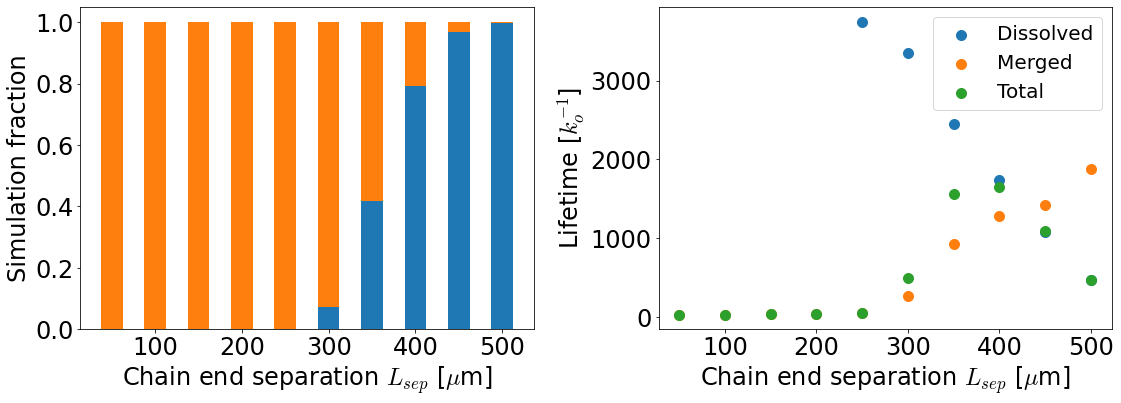

In [ ]:
data_path = (ceph_path /"MC_condensates/22-03-30_Quail825_scan10.1_sep100_size100_L50-500/simulations")
ss_ind = 0
end_ind = 4000
start_bead = 0
end_bead = -1

mean_lt = []
merge_mean = []
dis_mean = []
lsep = []
merge_frac = []
dis_frac = []
fig, axarr = plt.subplots(1,2, figsize=(16,6))
for h5_file in data_path.glob('*/*.h5'):
    print(h5_file)
    with h5py.File(h5_file, 'r+') as h5_data:
        params = yaml.safe_load(h5_data.attrs['params'])
        lsep += [params['kinetics']['L']]
        merge_mean += [h5_data.attrs['merge_mean_lifetime']]
        dis_mean += [h5_data.attrs['dissolve_mean_lifetime']]
        mean_lt += [h5_data.attrs['mean_lifetime']]
        merge_frac += [h5_data.attrs['merge_frac']]
        dis_frac += [h5_data.attrs['dissolve_frac']]


_ = axarr[0].bar(lsep, dis_frac, label='Dissolved', color=['tab:blue']*len(lsep), width=25)
_ = axarr[0].bar(lsep, merge_frac, label='Merged', bottom=dis_frac, color=['tab:orange']*len(lsep), width=25)

_ = axarr[1].scatter(lsep, dis_mean, label='Dissolved')
_ = axarr[1].scatter(lsep, merge_mean, label='Merged')
_ = axarr[1].scatter(lsep, mean_lt, label='Total')

_ = axarr[0].set_xlabel('Chain end separation $L_{{sep}}$ [$\mu$m]')
_ = axarr[1].set_xlabel('Chain end separation $L_{{sep}}$ [$\mu$m]')


_ = axarr[0].set_ylabel('Simulation fraction')
_ = axarr[1].set_ylabel('Lifetime [$k_o^{-1}$]')

_ = axarr[1].legend()
fig.tight_layout()

/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-05-31_Quail800_scan5.1_size100_L450_sep100-500/simulations/e0L100_e0R199_e1L600_e1R699_L450/e0L100_e0R199_e1L600_e1R699_L450.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-05-31_Quail800_scan5.1_size100_L450_sep100-500/simulations/e0L200_e0R299_e1L500_e1R599_L450/e0L200_e0R299_e1L500_e1R599_L450.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-05-31_Quail800_scan5.1_size100_L450_sep100-500/simulations/e0L250_e0R349_e1L450_e1R549_L450/e0L250_e0R349_e1L450_e1R549_L450.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-05-31_Quail800_scan5.1_size100_L450_sep100-500/simulations/e0L50_e0R149_e1L650_e1R749_L450/e0L50_e0R149_e1L650_e1R749_L450.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-05-31_Quail800_scan5.1_size100_L450_sep100-500/simulations/e0L150_e0R249_e1L550_e1R649_L450/e0L150_e0R249_e1L550_e1R649_L450.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-05-31_Quail800_scan5.1_siz

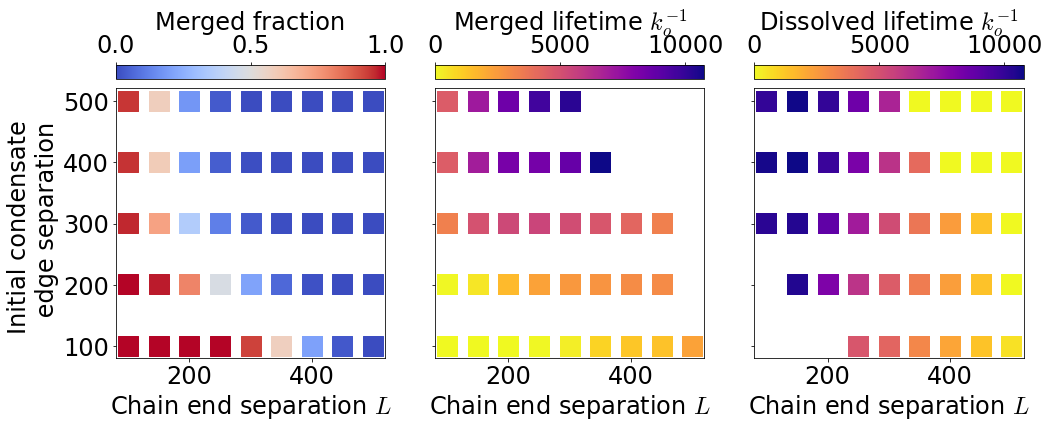

In [20]:
ss_ind = 0
end_ind = 4000
start_bead = 0
end_bead = -1

mean_lt = []
merge_mean = []
dis_mean = []
var_params = []
merge_frac = []
dis_frac = []
fig, axarr = plt.subplots(1,3, figsize=(15,6), sharey=True, sharex=True)
for ax in axarr:
    ax.set_box_aspect(1)

for h5_file in ceph_path.glob('MC_condensates/*Quail800_scan5.1_size100_L*sep100-500/simulations/*/*.h5'):
    print(h5_file)
    with h5py.File(h5_file, 'r+') as h5_data:
        params = yaml.safe_load(h5_data.attrs['params'])
        edge_sep = params['init_state'][1][0] - params['init_state'][0][1]
        var_params += [[params['kinetics']['L'], edge_sep]]
        merge_mean += [h5_data.attrs['merge_mean_lifetime']]
        dis_mean += [h5_data.attrs['dissolve_mean_lifetime']]
        mean_lt += [h5_data.attrs['mean_lifetime']]
        merge_frac += [h5_data.attrs['merge_frac']]
        dis_frac += [h5_data.attrs['dissolve_frac']]

# Masking to avoid plotting infinities
var_params = np.array(var_params)

merge_mean = np.array(merge_mean)
merge_mask = np.isfinite(merge_mean) & (merge_mean != 0)


merge_var_params = var_params[merge_mask,:]
merge_mean_mask = merge_mean[merge_mask]

dis_mean = np.array(dis_mean)
print(dis_mean)
dis_mask = np.isfinite(dis_mean) #& (dis_mean != 0)

dis_var_params = var_params[dis_mask,:]
dis_mean_mask = dis_mean[dis_mask]


plot_params = {'s':400, 'marker':'s'}

# Make sure colorbars have same range
max_color_bar = max(np.max(merge_mean),np.max(dis_mean))

# Scatter plot
_ = axarr[0].scatter(var_params[:,0], var_params[:,1], c=mpl.cm.coolwarm(merge_frac), **plot_params, )
cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.05)
_ = axarr[1].scatter(merge_var_params[:,0], merge_var_params[:,1], c=mpl.cm.plasma_r(merge_mean_mask/max_color_bar), **plot_params)
cax1 = make_axes_locatable(axarr[1]).append_axes("top", size="5%", pad=0.05)
_ = axarr[2].scatter(dis_var_params[:,0], dis_var_params[:,1], c=mpl.cm.plasma_r(dis_mean_mask/max_color_bar), **plot_params)
cax2 = make_axes_locatable(axarr[2]).append_axes("top", size="5%", pad=0.05)

# Color bars
cb0 = fig.colorbar(mpl.cm.ScalarMappable(cmap='coolwarm'), cax = cax0, orientation='horizontal', pad=0.1, label='Merged fraction', )
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.set_label_position('top')

cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax1, orientation='horizontal', pad=0.1, label='Merged lifetime $k_o^{-1}$', )
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), cax = cax2, orientation='horizontal', pad=0.1, label='Dissolved lifetime $k_o^{-1}$', )
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.xaxis.set_label_position('top')
# cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[1])
# cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[2])


# _ = cb0.set_label('Merge fraction', fontsize=22)
# _ = cb2.set_label('Mean time to event', fontsize=22)
_ = axarr[0].set_ylabel('Initial condensate \n edge separation')

for ax in axarr: 
    _ = ax.set_xlabel('Chain end separation $L$')

# Append axes to the right of ax, with 5% width of ax
# cax0 = divider.append_axes("top", size="5%", pad=0.05)
_ = axarr[1].scatter(merge_var_params[:,0], merge_var_params[:,1], c=mpl.cm.plasma_r(merge_mean_mask/np.max(merge_mean_mask)), **plot_params)
_ = axarr[2].scatter(dis_var_params[:,0], dis_var_params[:,1], c=mpl.cm.plasma_r(dis_mean_mask/np.max(dis_mean_mask)), **plot_params)

# cb0 = fig.colorbar(mpl.cm.ScalarMappable(cmap='coolwarm'), ax=axarr[0])
# cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[1])
# cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar),cmap='plasma_r'), ax=axarr[2])


# _ = cb0.set_label('Merge fraction', fontsize=22)
# _ = cb2.set_label('Mean time to event', fontsize=22)
_ = axarr[0].set_ylabel('Initial condensate \n edge separation')


for ax in axarr: 
    _ = ax.set_xlabel('Chain end separation $L$')

fig.tight_layout()
fig.savefig('Figure6/merge_frac_lifetime.pdf', bbox_inches='tight')